1) Milk.txt is a time series of monthly milk production per cow with values from 01/1962 to 12/1975. Separate the data into two parts: a time series from 01/1962 to 12/1973 and another time series from 01/1974 to 12/1975. 

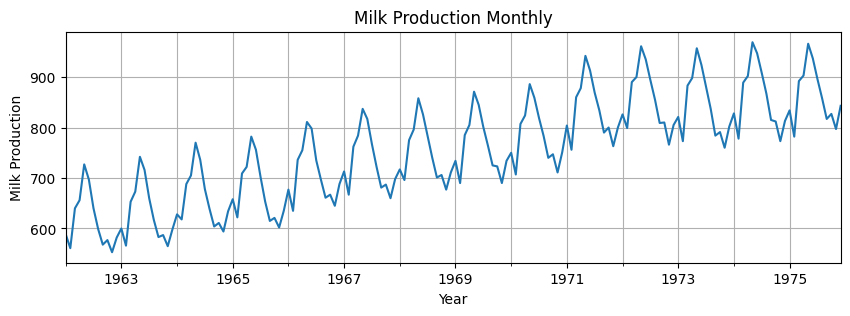

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

data = pd.read_csv(r"C:\Users\USER\Desktop\GitHub\Universidade-time-series\Dataset\milk.txt", header=None)

ts = pd.Series(data[0].values, index=pd.date_range("1-1962", periods=len(data), freq="ME"))

# Plotando a série temporal
plt.figure(figsize=(10, 3))
ts.plot()
plt.title("Milk Production Monthly")
plt.xlabel("Year")
plt.ylabel("Milk Production")
plt.grid(which='both')

# Separação dos conjuntos de treino e teste
ts_train = ts[:"1973-12"]
ts_test = ts["1974-01":]

- Perform the decomposition of the first part using STL decomposition and show the graphics. 
- Predict the production for the years 1974 to 1975 using the seasonality component of the STL and the autoregressive (AR) model to predict the trend + residual components. 
- Show the graphics of actual values and predicted values. 
- Calculate the MSE of the prediction. 

In Python, the following functions can be used:
- from statsmodels.tsa.seasonal import STL
- from statsmodels.tsa.ar_model import AutoReg


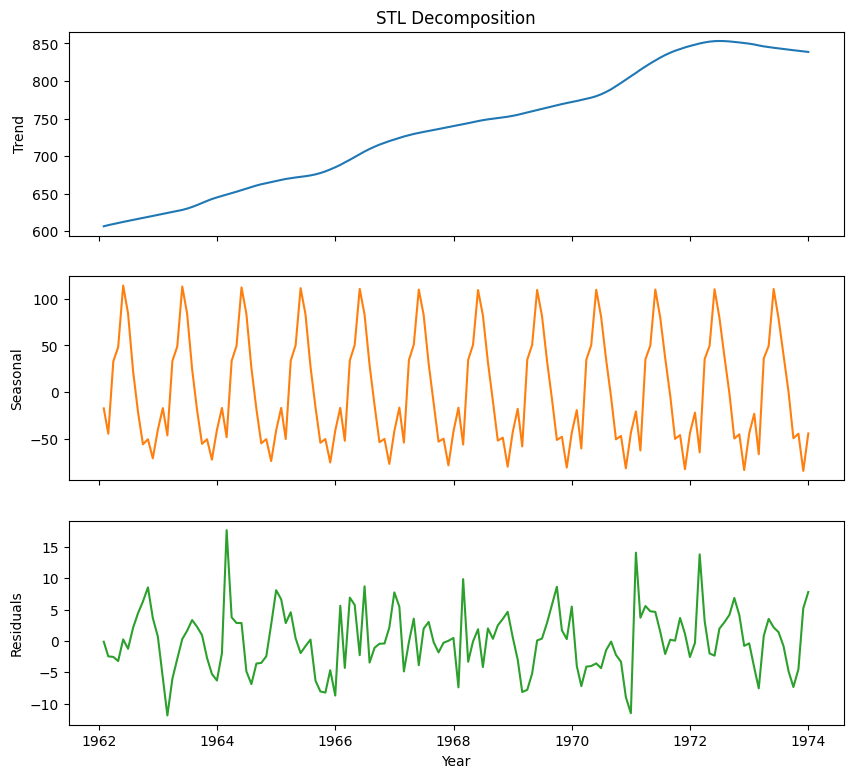

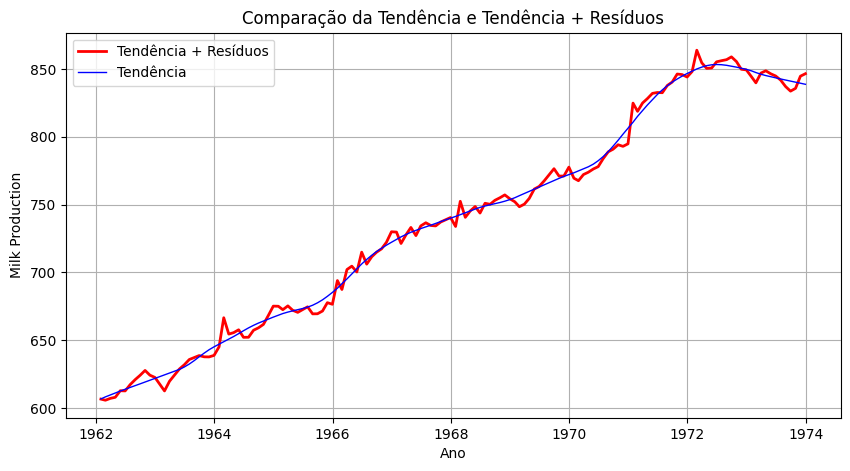

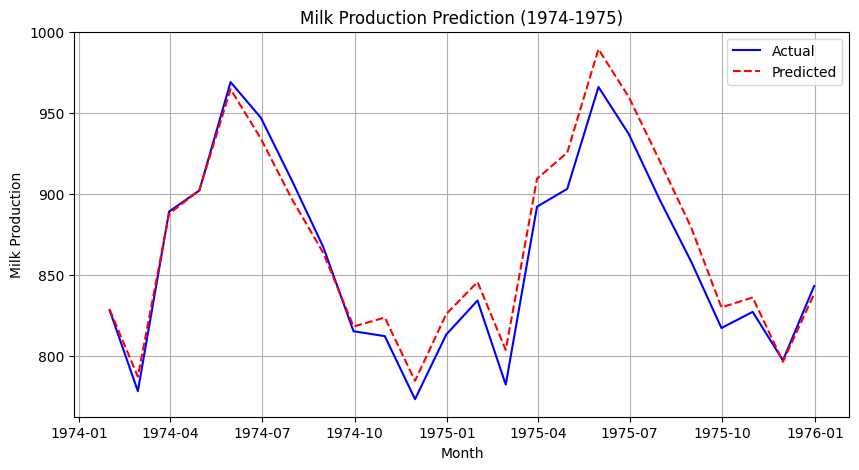

In [67]:
# seasonal – Define a janela da média móvel para suavizar a sazonalidade. 
# Deve ser ímpar maior ou igual ao período sazonal.
stl = STL(ts_train, seasonal=13) #sazonalidade mensal
STL_decomposition = stl.fit()

# Plotando a decomposição
fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)
axes[0].plot(STL_decomposition.trend, label='Trend', color='tab:blue')
axes[1].plot(STL_decomposition.seasonal, label='Seasonality', color='tab:orange')
axes[2].plot(STL_decomposition.resid, label='Residuals', color='tab:green')

axes[0].set_title('STL Decomposition')
axes[0].set_ylabel('Trend')
axes[1].set_ylabel('Seasonal')
axes[2].set_ylabel('Residuals')
axes[2].set_xlabel('Year')
plt.show()

trend_resid = STL_decomposition.trend + STL_decomposition.resid

# Gráfico de tendência + resíduos
fig = plt.figure(figsize=(10, 5))
plt.plot(trend_resid, c="red", lw=2, label="Tendência + Resíduos")
plt.plot(STL_decomposition.trend, c="blue", lw=1, label="Tendência")
plt.legend()
plt.title("Comparação da Tendência e Tendência + Resíduos")
plt.xlabel("Ano")
plt.ylabel("Milk Production")
plt.grid(which='both')
plt.show()

# Modelo Autorregressivo (AR) para previsão da tendência + resíduos
train_residual_trend = STL_decomposition.trend + STL_decomposition.resid
ar_model = AutoReg(train_residual_trend.dropna(), lags=24).fit()

ts_pred_trend_resid = ar_model.predict(start=len(train_residual_trend), end=len(train_residual_trend) + len(ts_test) - 1)
# Reconstituindo a previsão final
seasonal_test = STL_decomposition.seasonal[-12:].values  # Último ano de sazonalidade
seasonal_forecast = np.tile(seasonal_test, len(ts_test) // 12)
ts_pred = ts_pred_trend_resid.values + seasonal_forecast

# Plotando valores reais e previstos
plt.figure(figsize=(10, 5))
plt.plot(ts_test.index, ts_test, label="Actual", color="blue")
plt.plot(ts_test.index, ts_pred, label="Predicted", linestyle="dashed", color="red")
plt.xlabel("Month")
plt.ylabel("Milk Production")
plt.title("Milk Production Prediction (1974-1975)")
plt.grid(which='both')
plt.legend()
plt.show()


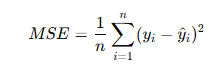

In [68]:
def mean_squared_error_implemented(y_true, y_pred):
    """
    Calcula o erro quadrático médio entre os valores reais e preditos.
    
    Parâmetros:
    - y_true: array-like, valores reais
    - y_pred: array-like, valores preditos
    
    Retorna:
    - mse: float, erro quadrático médio
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) ** 2)


# Avaliação do modelo
mse = mean_squared_error(ts_test, ts_pred)
mse_implemented = mean_squared_error_implemented(ts_test, ts_pred)
print(f"MSE Scikit-Learn: {mse:.2f}")
print(f"MSE Implemented: {mse_implemented:.2f}")

MSE Scikit-Learn: 191.29
MSE Implemented: 191.29


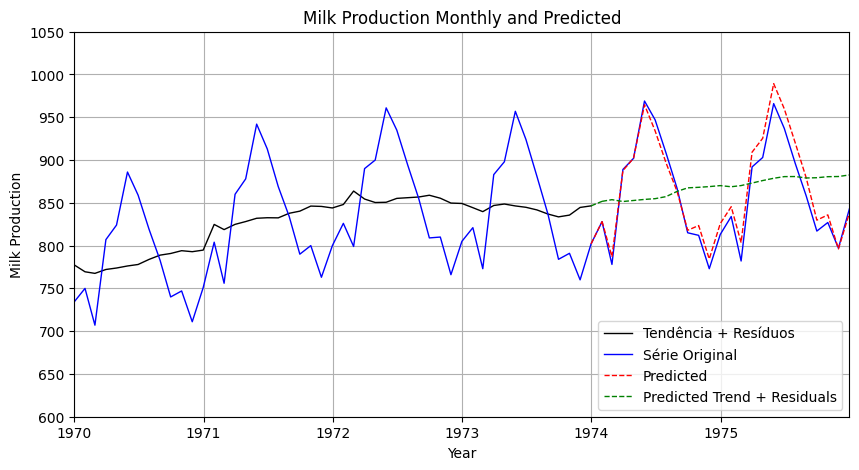

In [69]:
# Plotando a série temporal
plt.figure(figsize=(10, 5))
plt.plot(trend_resid, c="black", lw=1, label="Tendência + Resíduos")
plt.plot(ts, c="blue", lw=1, label="Série Original")
plt.plot(ts_test.index, ts_pred, label="Predicted", linestyle="dashed", color="red", lw=1)
plt.plot(ts_pred_trend_resid, label="Predicted Trend + Residuals", linestyle="dashed", color="green", lw=1)
#conexão entre a tendencia original e a tendencia previsão
plt.plot([trend_resid.index[-1], ts_pred_trend_resid.index[0]],[trend_resid.values[-1], ts_pred_trend_resid.values[0]], linestyle="dashed", color="green", lw=1)   
plt.plot([ts.index[-25], ts_test.index[0]],[ts.values[-25], ts_test.values[0]], linestyle="dashed", color="red", lw=1)   
plt.title("Milk Production Monthly and Predicted")
plt.xlim(pd.Timestamp("1970-01-01"), pd.Timestamp(f"{ts.index.max().year}-12-31"))
plt.ylim(600,1050)
plt.legend(loc="lower right")
plt.xlabel("Year")
plt.ylabel("Milk Production")
plt.grid(which='both')

2) For the industrial_process.txt time series, do: 
- convert the time series values to integer values, i.e., use the round function. 
- Then, you must compress the data by combining delta encoding and Fibonacci binary encoding methods. 
- Calculate the compression ratio (assume that the original time series values are represented by 32 bits) 
- Calculate the MSE of the reconstruction error. 

In [70]:
data = pd.read_csv(r"C:\Users\USER\Desktop\GitHub\Universidade-time-series\Dataset\industrial_process.txt", header=None)

ts = pd.Series(data[0]).round(0).astype(int)    

def delta_encoding(time_series):
    """
    Aplica Delta Encoding a uma série temporal.

    Parâmetro:
    - time_series (numpy array): Série temporal original.

    Retorna:
    - numpy array: Série codificada com diferenças sucessivas.
    """
    return np.insert(np.diff(time_series), 0, time_series[0])  # Mantém o primeiro valor original

ts_delta = delta_encoding(ts.values)

def fibonacci_series(n):
    """
    Gera a sequência de Fibonacci até um número n.
    
    Parâmetro:
    - n (int): Limite superior para a sequência de Fibonacci.
    
    Retorna:
    - numpy array: Sequência de Fibonacci até n.
    """
    fib = [1, 2]
    while fib[-1] <= n:
        fib.append(fib[-1] + fib[-2])
    return np.array(fib)

def fibonacci_binary_encoding(delta):
    """
    Codifica a sequência delta usando Fibonacci Binary Encoding.
    
    Parâmetro:
    - delta (numpy array): Série temporal codificada com diferenças sucessivas.

    Retorna:
    - comp_data (str): Sequência codificada.
    - binary_codes (dict): Dicionário com os códigos binários para cada símbolo.  
    """
    
    # Passo 1: Contar frequência dos elementos
    elements_count = {el: delta.tolist().count(el) for el in np.unique(delta)}
    
    # Passo 2: Ordenar símbolos por frequência
    sorted_symbols = sorted(elements_count, key=elements_count.get, reverse=True)
    
    # Passo 3: Gerar sequência de Fibonacci
    fib = fibonacci_series(len(elements_count))
    fib_rev = fib[::-1]  # Inverte para facilitar busca
    
    # Passo 4: Criar código Fibonacci para cada símbolo
    binary_codes = {}
    for rank, symbol in enumerate(sorted_symbols):
        aux = rank + 1
        idx = next(i for i, val in enumerate(fib_rev) if val <= aux)
        aux -= fib_rev[idx]
        code = ["11"]

        for i in range(idx + 1, len(fib_rev)):
            if aux >= fib_rev[i]:
                code.append("1")
                aux -= fib_rev[i]
            else:
                code.append("0")

        binary_codes[symbol] = ''.join(code[::-1])  # Inverter string final
    
    # Passo 5: Criar sequência codificada
    comp_data = ''.join(binary_codes[val] for val in delta)

    return comp_data, binary_codes

ts_fbe, dict_ts_fbe = fibonacci_binary_encoding(ts_delta)

#Taxa de Compressão int ou float 
comp_ratio = len(ts_fbe)/(len(ts)*32)
print(f'taxa de compressão: {comp_ratio*100:.4f} %')

taxa de compressão: 6.7372 %


In [71]:
def fibonacci_decode(comp_data, binary_codes):
    """
    Decodifica uma sequência codificada com Fibonacci Binary Encoding.

    Parâmetros:
    - comp_data (str): Sequência codificada.
    - binary_codes (dict): Dicionário {símbolo: código binário}.

    Retorna:
    - numpy array: Sequência delta decodificada.
    """
    # Inverter o dicionário para mapear códigos -> valores originais
    reverse_dict = {v: k for k, v in binary_codes.items()}
    
    delta_decoded = []
    buffer = ""
    
    for bit in comp_data:
        buffer += bit
        if buffer in reverse_dict:
            delta_decoded.append(reverse_dict[buffer])
            buffer = ""  # Resetar buffer
    
    return np.array(delta_decoded)

def delta_decode(dc_list):
    """
    Decodifica uma sequência delta para recuperar a série original.

    Parâmetros:
    - dc_list (numpy array): Sequência delta codificada.
    - first_value (int): Primeiro valor da série original.

    Retorna:
    - numpy array: Série temporal reconstruída.
    """
    return np.cumsum(dc_list)
    


decoded_delta = fibonacci_decode(ts_fbe, dict_ts_fbe)
ts_reconstructed = delta_decode(decoded_delta)

# Avaliação do modelo
mse = mean_squared_error(ts, ts_reconstructed)
mse_implemented = mean_squared_error_implemented(ts, ts_reconstructed)
print(f"MSE Scikit-Learn: {mse:.2f}")
print(f"MSE Implemented: {mse_implemented:.2f}")

MSE Scikit-Learn: 0.00
MSE Implemented: 0.00



Show the graphics for the original time series and the reconstructed time series. What consequence on MSE and compression ratio if the data were not rounded to integer values?

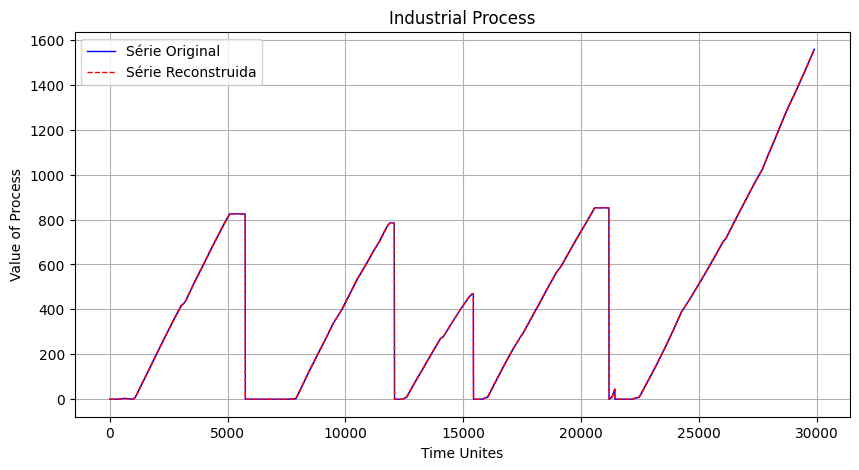

In [73]:
fig = plt.figure(figsize=(10, 5))
plt.plot(ts, c="blue", lw=1, label="Série Original")
plt.plot(ts_reconstructed, c="red", lw=1, label="Série Reconstruida",linestyle="dashed")
plt.title("Industrial Process")
plt.legend(loc="upper left")
plt.xlabel("Time Unites")
plt.ylabel("Value of Process")
plt.grid(which='both')
plt.show()

3. Design the Huffman coding for the symbols of the table. Calculate the compression ratio (assume that the symbols are represented by 8 bits). This question can be done manually.

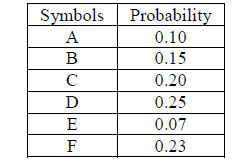